# 1. 보스톤 주택가격 모델

## 1-1. 데이터 불러오기 및 전처리

In [12]:
# boston_housing 데이터셋 로드
from keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# 데이터셋의 크기 확인
print(f'Train samples: {len(train_data)}')
print(f'Test samples: {len(test_data)}')

Train samples: 404
Test samples: 102


In [13]:
# 데이터 표준화 (훈련 데이터 기준으로 평균, 표준편차 계산)
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

## 1-2. 모델 구성 및 컴파일

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import matplotlib.pyplot as plt

In [14]:
# Subclassed 모델 정의
class HousePriceModel(models.Model):
  def __init__(self, **kwargs):
    super(HousePriceModel, self).__init__(**kwargs)
    self.dense1 = layers.Dense(64, activation='relu')
    self.dense2 = layers.Dense(64, activation='relu')
    self.output_layer = layers.Dense(1)

  def call(self, inputs):
      x = self.dense1(inputs)
      x = self.dense2(x)
      
      return self.output_layer(x)

In [16]:
# 모델 인스턴스 생성 및 빌드
model = HousePriceModel()
model.build(input_shape=(None, train_data.shape[1]))
model.summary()

# 모델 컴파일
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

Model: "house_price_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             multiple                  896       
                                                                 
 dense_10 (Dense)            multiple                  4160      
                                                                 
 dense_11 (Dense)            multiple                  65        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## 1-3. 모델 훈련 및 평가

In [21]:
# 콜백 정의
checkpoint_cb = callbacks.ModelCheckpoint('best_boston_model',
                                          save_format='tf', 
                                          save_best_only=True) 
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True)

# 학습
history = model.fit(train_data, train_labels,
                    epochs=64,
                    batch_size=16,
                    validation_split=0.2,   # 학습 데이터 중 20%를 검증용으로 자동 분리
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/64
21/21 [==============================] - 0s 17ms/step - loss: 9.1731 - mae: 2.1203 - val_loss: 12.7072 - val_mae: 2.6646
Epoch 2/64
21/21 [==============================] - 0s 17ms/step - loss: 9.0064 - mae: 2.0923 - val_loss: 12.6567 - val_mae: 2.6173
Epoch 3/64
21/21 [==============================] - 0s 7ms/step - loss: 8.9692 - mae: 2.0832 - val_loss: 12.7203 - val_mae: 2.6504
Epoch 4/64
21/21 [==============================] - 0s 17ms/step - loss: 8.8196 - mae: 2.0628 - val_loss: 12.3842 - val_mae: 2.6090
Epoch 5/64
21/21 [==============================] - 0s 17ms/step - loss: 8.7719 - mae: 2.0578 - val_loss: 12.3807 - val_mae: 2.6095
Epoch 6/64
21/21 [==============================] - 0s 4ms/step - loss: 8.6533 - mae: 2.0596 - val_loss: 12.7425 - val_mae: 2.6545
Epoch 7/64
21/21 [==============================] - 0s 3ms/step - loss: 8.6542 - mae: 2.0689 - val_loss: 12.5633 - val_mae: 2.6630
Epoch 8/64
21/21 [==============================] - 0s 3ms/step - loss: 8.6450 

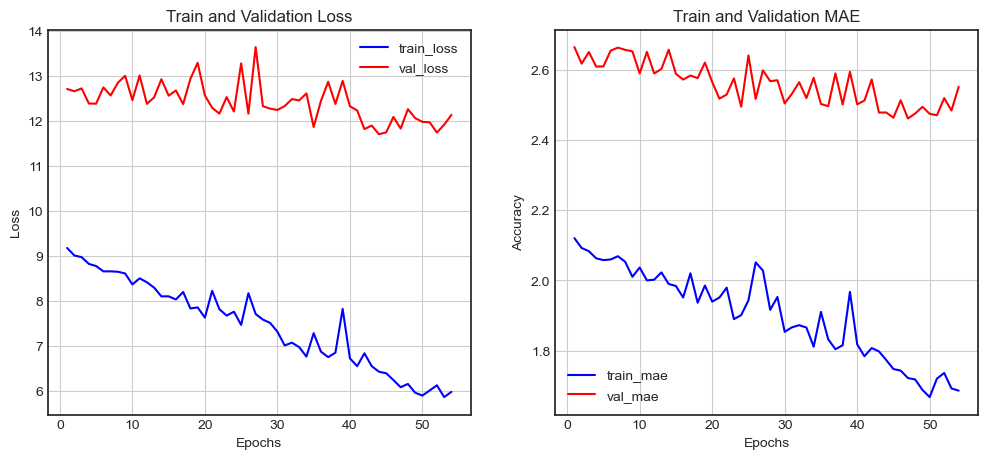

In [22]:
# 모델 학습 히스토리에서 loss, val_loss, mae, val_mae를 차트로 보여줍니다.
plt.style.use("seaborn-v0_8-white")

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, 'b-', label='train_mae')
ax2.plot(epochs, val_mae, 'r-', label='val_mae')
ax2.set_title('Train and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [23]:
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 1ms/step - loss: 20.1110 - mae: 2.8960


[20.11096954345703, 2.8960206508636475]

# 2. Reuters 모델

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

## 2-1. 데이터 불러오기 및 전처리

In [14]:
# 데이터 로드
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# 인풋 데이터 원핫 인코딩 함수
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

# 핫 인코딩 -> X_train , X_test 
X_train = one_hot_encoding(train_data)
X_test = one_hot_encoding(test_data)
print(X_train[0]) # 원핫 인코딩 결과 확인 출력

# 카테고리컬 형태로 변환 -> y_train, y_test 
y_train = utils.to_categorical(train_labels)
y_test = utils.to_categorical(test_labels)
print(train_labels[0], y_train[0]) # 레이블 카터고리컬 인코딩 확인 출력

# 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# 데이터 크기 출력
print(f'Train samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')
print(f'Test samples: {len(X_test)}')

# 훈련 데이터 라벨 클래스 개수 출력
print(f'Number of classes in training data: {len(set(test_labels))}')

[0. 1. 1. ... 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Train samples: 6736
Validation samples: 2246
Test samples: 2246
Number of classes in training data: 46


In [10]:
word_index = reuters.get_word_index()
# word_index
index_word = dict([(value, key) for (key, value) in word_index.items()])
# index_word
news = ' '.join([index_word.get(i-3, '?') for i in train_data[0]])
news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## 2-2. 모델 구성 및 컴파일

In [11]:
# Subclassed 모델 정의
class ReutersModel(models.Model):
    def __init__(self):
        super(ReutersModel, self).__init__()
        
        # 첫 번째 은닉층
        self.dense1 = layers.Dense(128, name='input')
        self.bn1 = layers.BatchNormalization()
        self.activation1 = layers.Activation('relu')
        self.dropout1 = layers.Dropout(0.5)
        
        # 두 번째 은닉층
        self.dense2 = layers.Dense(128, name='hidden')
        self.bn2 = layers.BatchNormalization()
        self.activation2 = layers.Activation('relu')
        self.dropout2 = layers.Dropout(0.5)
        
        # 출력층
        self.output_layer = layers.Dense(46, activation='softmax', name='output')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = self.activation1(x)
        x = self.dropout1(x, training=training)

        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.activation2(x)
        x = self.dropout2(x, training=training)

        return self.output_layer(x)

In [17]:
model = ReutersModel()
model.build(input_shape=(None, 10000))  # 배치 크기는 None 자유롭게 fit 단계에서 설정, feature 크기는 10000
model.summary()

# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "reuters_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               multiple                  1280128   
                                                                 
 batch_normalization_4 (Batc  multiple                 512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   multiple                  0         
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 hidden (Dense)              multiple                  16512     
                                                                 
 batch_normalization_5 (Batc  multiple                 512       
 hNormalization)                                   

## 2-3. 모델 훈련 및 평가

In [18]:
# 콜백 정의
checkpoint_cb = callbacks.ModelCheckpoint('best_reuters_model',
                                          save_format='tf', 
                                          save_best_only=True) 
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True)

# 학습
history = model.fit(X_train, y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/40
14/14 [==============================] - 3s 175ms/step - loss: 3.3408 - accuracy: 0.2577 - val_loss: 3.4481 - val_accuracy: 0.5744
Epoch 2/40
14/14 [==============================] - 2s 146ms/step - loss: 1.9392 - accuracy: 0.5864 - val_loss: 2.9829 - val_accuracy: 0.6505
Epoch 3/40
14/14 [==============================] - 2s 152ms/step - loss: 1.4913 - accuracy: 0.6689 - val_loss: 2.6170 - val_accuracy: 0.6919
Epoch 4/40
14/14 [==============================] - 2s 152ms/step - loss: 1.2451 - accuracy: 0.7179 - val_loss: 2.3348 - val_accuracy: 0.7173
Epoch 5/40
14/14 [==============================] - 2s 135ms/step - loss: 1.1000 - accuracy: 0.7411 - val_loss: 2.1216 - val_accuracy: 0.7262
Epoch 6/40
14/14 [==============================] - 2s 134ms/step - loss: 0.9802 - accuracy: 0.7692 - val_loss: 1.9401 - val_accuracy: 0.7333
Epoch 7/40
14/14 [==============================] - 2s 146ms/step - loss: 0.8824 - accuracy: 0.7928 - val_loss: 1.7862 - val_accuracy: 0.7315
Epoch 

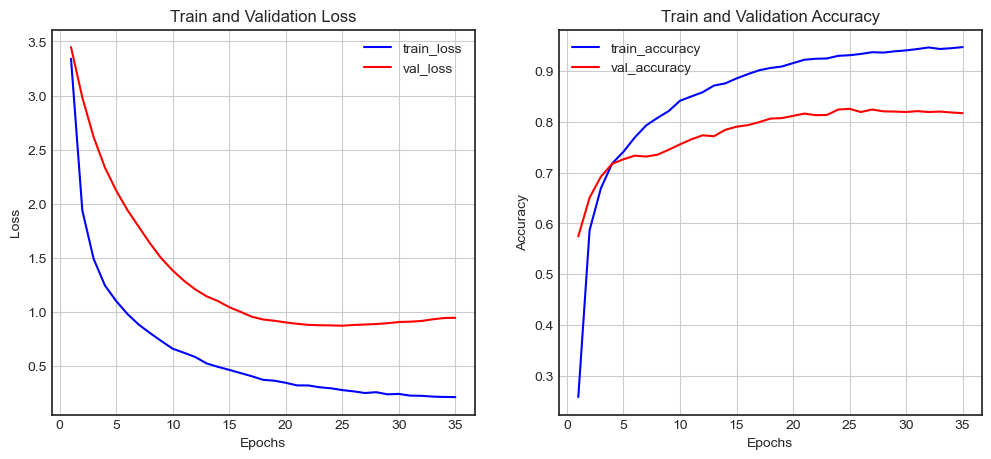

In [20]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use("seaborn-v0_8-white")

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [21]:
model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 0.9583 - accuracy: 0.8028


[0.958274245262146, 0.8027604818344116]

# 3. CIFAR10 모델

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10

## 2-1. 데이터 불러오기 및 전처리

In [52]:
# 데이터 로드
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
# 훈련 데이터셋에서 20%를 검증 데이터셋으로 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력
print("전체 학습 데이터: {} 레이블: {}".format(X_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(X_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(X_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(X_test.shape, y_test.shape))

전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (40000, 32, 32, 3) 레이블: (40000, 1)
검증 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


In [53]:
# cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 
# 'dog', 'frog', 'horse', 'ship', 'truck'를 class_name으로 정의
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

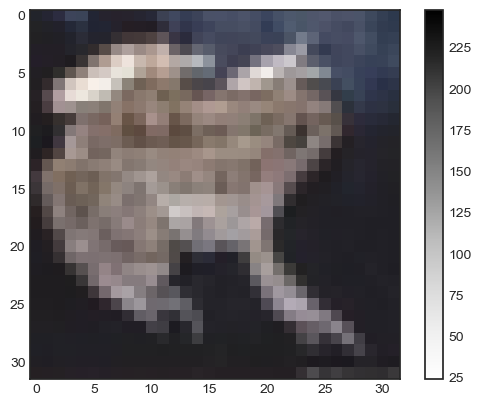

In [54]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화
plt.style.use("seaborn-v0_8-white")

plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.show()

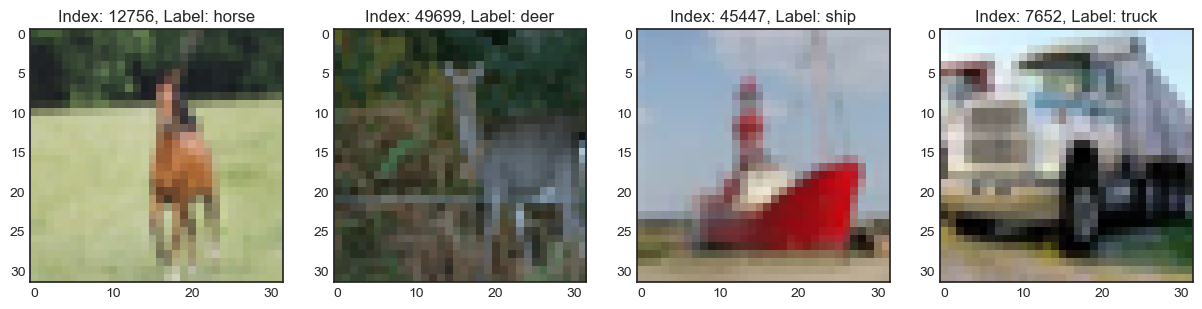

In [55]:
num_sample = 4
random_idxs = np.random.randint(50000, size=num_sample)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_idxs):
    image = X_train_full[idx, :]
    label = int(y_train_full[idx])
    plt.subplot(1, len(random_idxs), i+1)
    plt.imshow(image)
    plt.title(f'Index: {idx}, Label: {class_names[label]}')

In [56]:
# 훈련, 검증, 테스트 데이터의 형태(shape) 출력
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [57]:
# 입력 데이터 flatten
X_train = X_train.reshape((X_train.shape[0], 32 * 32 * 3))
X_val = X_val.reshape((X_val.shape[0], 32 * 32 * 3))
X_test = X_test.reshape((X_test.shape[0], 32 * 32 * 3))

In [58]:
# 훈련, 검증, 테스트 데이터를 255로 나누어 0~1 사이의 값으로 변환
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

## 2-2. 모델 구성 및 컴파일

In [76]:
# Subclassed 모델 정의
class ReutersModel(models.Model):
    def __init__(self):
        super(ReutersModel, self).__init__()
        
        # 첫 번째 은닉층
        self.dense1 = layers.Dense(512, name='input')
        self.bn1 = layers.BatchNormalization()
        self.activation1 = layers.Activation('relu')
        self.dropout1 = layers.Dropout(0.2)
        
        # 두 번째 은닉층
        self.dense2 = layers.Dense(512, name='hidden')
        self.bn2 = layers.BatchNormalization()
        self.activation2 = layers.Activation('relu')
        self.dropout2 = layers.Dropout(0.2)
        
        # 출력층
        self.output_layer = layers.Dense(10, activation='softmax', name='output')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = self.activation1(x)
        x = self.dropout1(x, training=training)

        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.activation2(x)
        x = self.dropout2(x, training=training)

        return self.output_layer(x)

In [77]:
model = ReutersModel()
model.build(input_shape=(None, 3072)) 

# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 2-3. 모델 훈련 및 평가

In [78]:
# 콜백 정의
checkpoint_cb = callbacks.ModelCheckpoint('best_cifar10_model',
                                          save_format='tf', 
                                          save_best_only=True) 
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True)

# 학습
history = model.fit(X_train, y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/40
79/79 [==============================] - 3s 27ms/step - loss: 1.8002 - accuracy: 0.3688 - val_loss: 2.1557 - val_accuracy: 0.2637
Epoch 2/40
79/79 [==============================] - 1s 19ms/step - loss: 1.5415 - accuracy: 0.4528 - val_loss: 1.8976 - val_accuracy: 0.3238
Epoch 3/40
79/79 [==============================] - 1s 18ms/step - loss: 1.4313 - accuracy: 0.4881 - val_loss: 1.7372 - val_accuracy: 0.3640
Epoch 4/40
79/79 [==============================] - 1s 8ms/step - loss: 1.3564 - accuracy: 0.5160 - val_loss: 1.7855 - val_accuracy: 0.3868
Epoch 5/40
79/79 [==============================] - 1s 19ms/step - loss: 1.2970 - accuracy: 0.5359 - val_loss: 1.7336 - val_accuracy: 0.3816
Epoch 6/40
79/79 [==============================] - 2s 19ms/step - loss: 1.2424 - accuracy: 0.5560 - val_loss: 1.7122 - val_accuracy: 0.3927
Epoch 7/40
79/79 [==============================] - 2s 20ms/step - loss: 1.1943 - accuracy: 0.5741 - val_loss: 1.5162 - val_accuracy: 0.4611
Epoch 8/40
79/

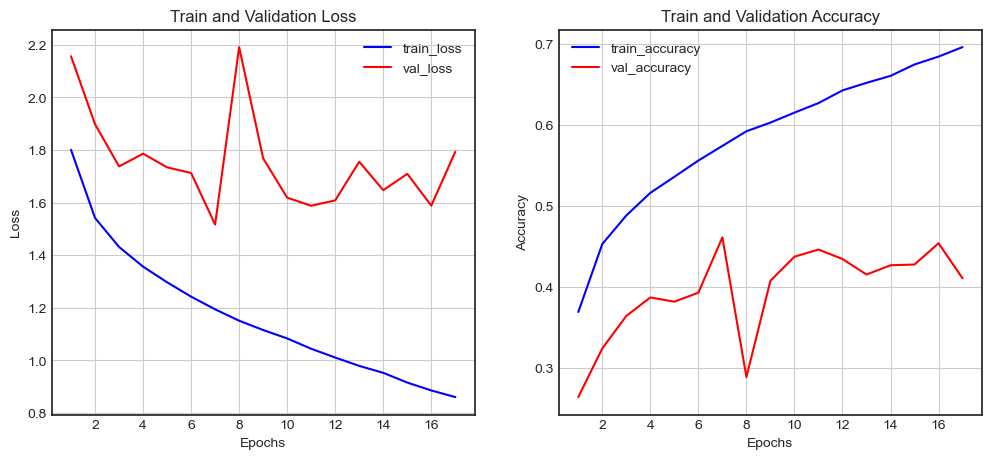

In [79]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화
plt.style.use("seaborn-v0_8-white")

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [80]:
def add_eval_result(results_dict, model, X_test, y_test):
    idx = len(results_dict) + 1
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    key = f'test_{idx}'
    results_dict[key] = [loss, acc]

eval_results = {}

# 평가 실행 & 저장 예
add_eval_result(eval_results, model, X_test, y_test)

df = pd.DataFrame.from_dict(eval_results, orient='index', columns=['loss', 'accuracy'])
df

,loss,accuracy
test_1,1.502003,0.4713
test_2,1.502003,0.4713


test_1. 히든레어(2) 크기: 128

test_2. 히든레어(2) 크기: 512 